<a href="https://colab.research.google.com/github/JohannRannou/TD3bis/blob/main/TD_3_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

at day 0.0 : theta = 0.0, omega = 0.0, r = 173363.94900000005
. . . . .
[[ 8.71271741e+04 -5.09528811e-12]
 [ 8.90975950e+04 -4.86007301e-12]
 [ 9.24516670e+04 -4.54505566e-12]
 [ 9.71343164e+04 -4.15540861e-12]
 [ 1.03068654e+05 -3.69752987e-12]
 [ 1.10157239e+05 -3.17893780e-12]
 [ 1.18283676e+05 -2.60814765e-12]
 [ 1.27314530e+05 -1.99453179e-12]
 [ 1.37101514e+05 -1.34816577e-12]
 [ 1.47483926e+05 -6.79662908e-13]
 [ 1.58291287e+05 -1.30179149e-27]
 [ 1.58291287e+05  0.00000000e+00]
 [ 1.69346141e+05  6.79662908e-13]
 [ 1.80466968e+05  1.34816577e-12]
 [ 1.91471162e+05  1.99453179e-12]
 [ 2.02178037e+05  2.60814765e-12]
 [ 2.12411786e+05  3.17893780e-12]
 [ 2.22004370e+05  3.69752987e-12]
 [ 2.30798280e+05  4.15540861e-12]
 [ 2.38649119e+05  4.54505566e-12]
 [ 2.45427978e+05  4.86007301e-12]
 [ 2.51023548e+05  5.09528811e-12]
 [ 2.55343949e+05  5.24683871e-12]
 [ 2.58318240e+05  5.31223636e-12]
 [ 2.59897585e+05  5.29040725e-12]]
[<matplotlib.lines.Line2D object at 0x7f73018a8220>,

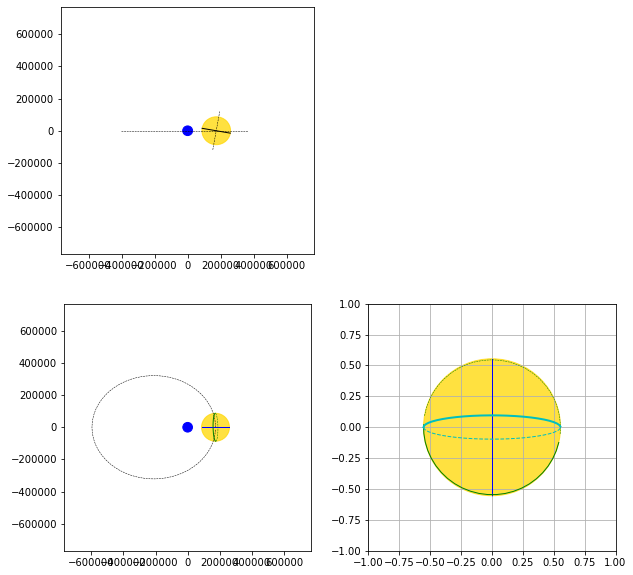

In [1]:
"""

https://nickcharlton.net/posts/drawing-animating-shapes-matplotlib.html
"""


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.animation as animation

from numpy import cos, sin
from numpy import cos
from numpy import sin
from numpy import pi



TWOPI = 2 * pi



class Libration():
    """Calcule les paramètres de l'orbite lunaire pour mettre en évidence la libration
       - orbite elliptique
       - inclinaison de l'orbite par rapport à l'écliptique et inclinaison de l'axe de rotation lunaire
       - calcul du paralaxe entre observation à l'aube ou au crépuscule

       On peut ainsi mettre en évidence, indépendamment et en exagérant les paramètres :
       - la libration en longitude
       - la libration en latitude
       - la libration de paralaxe

       par contre, on ne mettra pas en évidence la libration physique


    """
    def __init__(self):
        self.time = 0.

        # Paramètres du problème
        self.ellipticity = 0.05490               # Ellipticité de l'orbite lunaire
        self.a = 384399                     # demi grand axe de l'orbite lunaire (km)
        self.b = self.a*np.sqrt(1-self.ellipticity**2)                     # demi petit axe de l'orbite lunaire (km)
        self.c = np.sqrt(self.a**2 - self.b**2)                            # distance centre-foyer (km)
        self.earth_axis_inclination = np.radians(23.44)    # Obliquité : inclinaison de l'axe de rotation de la Terre par rapport au plan de l'écliptique
        self.orbit_inclination = np.radians(5.145)       # Inclinaison de l'orbite lunaire par rapport au plan de l'écliptique
        self.moon_axis_inclination = np.radians(6.68)   # Inclinaison de l'axe de rotation de la Lune par rapport au plan de son orbite autour de la Terre
        self.T = 27.321                       # Période de rotation (sidérale ?) de la Lune
        self.earth_radius = 12000/2*5           # Rayon de la Terre (km)
        self.moon_radius = 1736.*50            # Rayon de la Lune (km)


        # Pour modifier temporairement les paramètres pour faire des expériences
        self._modify()

        # Relations
        self.alpha = self.orbit_inclination - self.moon_axis_inclination # angle en radian entre l'équateur de la Lune et le plan de l'écliptique


        # Paramètres d'état
        self._theta = 0.               # coordonnée angulaire du référentiel géocentrique
        self._omega = 0.               # paramètre de rotation propre de la Lune
        self._r = 0.                   # coordonnée de distance du référenciel géocentrique
        self._x = 0.                   # x,y,z : 3 paramètres cartésien dans le référentiel géocentrique
        self._y = 0.
        self._z = 0.
        self._face_radius = 1.


    def _modify(self):
        """Modify parameters to highlight a specific phenomenon
        """
        self.orbit_inclination = np.radians(0)       # Inclinaison en ° de l'orbite lunaire par rapport au plan de l'écliptique (°)
        self.moon_axis_inclination = np.radians(10)   # Inclinaison en ° de l'axe de rotation de la Lune par rapport au plan de son orbite autour de la Terre
        self.ellipticity = 0.05490*10               # Ellipticité de l'orbite lunaire

        self.T = 10.

    
    def set_time(self,time):
        """
        time in days
        """
        self.time = time


    def _compute_rotation_matrices(self):
        """Calcule les matrices de rotation
        
        Voir notes manuscripts.
        """

        self.P_l_lp = np.eye(3)
        self.P_lp_o = np.eye(3)
        self.P_o_theta = np.eye(3)

        self.P_l_lp[1,1] = cos(-self._omega + pi/2)
        self.P_l_lp[2,1] = sin(-self._omega + pi/2)
        self.P_l_lp[1,2] = -sin(-self._omega + pi/2)
        self.P_l_lp[2,2] = cos(-self._omega + pi/2)

        self.P_lp_o[0,0] = cos(-self.alpha)
        self.P_lp_o[1,0] = sin(-self.alpha)
        self.P_lp_o[0,1] = -sin(-self.alpha)
        self.P_lp_o[1,1] = cos(-self.alpha)

        self.P_o_theta[1,1] = cos(self._theta)
        self.P_o_theta[2,1] = sin(self._theta)
        self.P_o_theta[1,2] = -sin(self._theta)
        self.P_o_theta[2,2] = cos(self._theta)

    def update(self, time):
        """
        time in days
        """
        self.set_time(time)
        self._theta = self.time / self.T * 2 * np.pi
        self.get_distance()
        self.compute_orbit_XYZ()
        self.compute_omega()
        self.compute_beta()
        self.compute_face_radius()
        self._compute_rotation_matrices()
        print(f'at day {self.time} : theta = {self._theta*360/TWOPI}, omega = {self._omega*360/TWOPI}, r = {self._r}')

    def get_distance(self, theta=None):
        """Renvoi la distance Terre-Lune (r)
        
        see https://en.wikipedia.org/wiki/Kepler%27s_laws_of_planetary_motion

        """

        p = self.a*(1-self.ellipticity**2)

        if theta==None:
            theta = self.time/self.T *2 * np.pi
        self._r = p/(1+self.ellipticity * np.cos(theta))

        return self._r

    def compute_face_radius(self):
        """Retourne le diamètre apparent de la Lune en °
        """
        # self._face_radius = self.moon_radius*self.a / self._r*360/TWOPI
        self._face_radius = 0.25 * self.a / self._r

    def compute_omega(self):
        # Pour l'instant c'est faux, ça pointe vers le centre de l'ellipse

        self._omega = np.arctan2(self._y , (self._x + self.a*self.ellipticity))

    def compute_beta(self):

        self._omega = np.arctan2(self._y , (self._x + self.a*self.ellipticity))
        


    def compute_orbit_XYZ(self, theta=None):
        """Renvoi les coordonnées cartésiennes de la lune dans le référentiel geocentrique.

        note : le référentiel géocentrique -> e_x et et e_y sont dans le plan de l'écliptique 

        """


        if theta == None :
            theta = self.time/self.T * 2 * np.pi

        self.get_distance(theta)
        self._x = self._r * cos(theta) 
        self._y = self._r * sin(theta) 
        self._z = self._x * np.tan(self.orbit_inclination)

        return self._x, self._y, self._z 

    
    


class LibrationPlot(Libration):
    """Complète la classe Libration avec des fonction qui tracent les éléments à afficher

    Il y a plusieurs vues :
        * vue de face
        * vue de dessus

    """

    def __init__(self):
        Libration.__init__(self)

        self.fig = plt.figure(figsize=(10, 10))



        self.top_orbit_axis = self.fig.add_subplot(223, autoscale_on=False, xlim=(-2*self.a, 2*self.a), ylim=(-2*self.a, 2*self.a))
        self.moon_face_axis = self.fig.add_subplot(224, autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))
        self.front_orbit_axis = self.fig.add_subplot(221, autoscale_on=False, xlim=(-2*self.a, 2*self.a), ylim=(-2*self.a, 2*self.a))
        self.top_orbit_axis.set_aspect('equal')
        self.moon_face_axis.set_aspect('equal')
        self.top_orbit_axis.grid()
        self.moon_face_axis.grid()
        self.top_orbit_axis.grid()



        top_earth_disc = plt.Circle((0, 0), self.earth_radius, color='b')
        self.top_orbit_axis.add_patch(top_earth_disc)
        front_earth_disc = plt.Circle((0, 0), self.earth_radius, color='b')
        self.front_orbit_axis.add_patch(front_earth_disc)




        # Disque lunaire
        self.top_moon_disc = plt.Circle((self.a, 0), self.moon_radius, color='gold', alpha=0.75)
        self.top_orbit_axis.add_patch(self.top_moon_disc)
        self.plot_moon_orbit_segments()
    

        self.meridian_angles = [np.radians(0), np.radians(89) ]
        self.meridian_colors = ['b', 'g' ]

    def _plot_ellipse(self, original_circle_function, rotation, translation=[0,0], permutation=(0, 1 ,2)):
        """Trace un cercle reprojeté dans une base donnée par la matrice de rotation 
            original_circle_function est une fonction du paramètres t qui retourne un vecteur de taille 3
            Translation est un vecteur 2 qui rajoute une translation

            La fonction retourne deux vecteurs position : front et back
        """
        # Nombre de points pour définir l'ellipse
        N = 50
        # t paramétrise le cercle initial
        t_list = np.linspace( 0, 2 * np.pi , N)
        pos = np.empty((N, 3))
        for i, t in enumerate(t_list):
            X_theta = rotation @ original_circle_function(t)
            pos[i,0] = translation[0] + X_theta[permutation[0]]
            pos[i,1] = translation[1] + X_theta[permutation[1]]
            pos[i,2] = X_theta[permutation[2]]


        # On filtre ce qui est à l'avant de ce qui est à l'arrière
        is_front = pos[:,2]>0
        front_pos = pos[is_front,:2]
        back_pos = pos[(np.logical_not(is_front)),:2]

        # Pour éviter les lignes droites de "lien", on tri
       
        abs_diff = np.absolute(np.diff(front_pos, axis=0))
        sort_ = np.argsort(abs_diff, axis=0)
        max_ = sort_[-1]
        if abs_diff[sort_[-1,0],0] > 2 * abs_diff[sort_[-2,0],0]:
            f_sort = np.roll(front_pos, -max_[0]-1, axis=0)
        elif abs_diff[sort_[-1,1],1] > 2 * abs_diff[sort_[-2,1],1]:
            f_sort = np.roll(front_pos, -max_[1]-1, axis=0)
        else:
            f_sort = front_pos
  

        abs_diff = np.absolute(np.diff(back_pos, axis=0))
        sort_ = np.argsort(abs_diff, axis=0)
        max_ = sort_[-1]
        if abs_diff[sort_[-1,0],0] > 2 * abs_diff[sort_[-2,0],0]:
            b_sort = np.roll(back_pos, -max_[0]-1, axis=0)
        elif abs_diff[sort_[-1,1],1] > 2 * abs_diff[sort_[-2,1],1]:
            b_sort = np.roll(back_pos, -max_[1]-1, axis=0)
        else:
            b_sort = back_pos



        print('. . . . .')
        print(f_sort)


    # #   
        # b_ind = np.argsort(back_pos[:,0])
        # b_sort = back_pos[b_ind,:2]
        # b_sort = back_pos

        # return front_pos, back_pos
        return f_sort, b_sort
        
    def plot_top_moon_disc(self):
        """Trace le disque lunaire (à updater)
        """
        x, y, z = self.compute_orbit_XYZ()
        self.top_moon_disc.center = (x, y)
        return [self.top_moon_disc]


    def plot_front_moon_disc(self):
        """Trace le disque lunaire (à updater)
        """
        try:
            self.front_moon_disc
        except:
            self.front_moon_disc = plt.Circle((self.a, 0), self.moon_radius, color='gold', alpha=0.75)
            self.front_orbit_axis.add_patch(self.front_moon_disc)

        self.front_moon_disc.center = (self._x, self._z)


  
    def plot_moon_orbit_segments(self):
        """Trace l'orbite elliptique de la Lune (statique)
        sur les vues de face et de dessus
        """
        self.moon_orbit_segments, = self.top_orbit_axis.plot([], [], '--', lw=0.5, color='k')
        N=100
        pos = np.empty((N, 2))
        for i, pos_i in enumerate(pos):
            x, y, z = self.compute_orbit_XYZ(i*np.pi*2/N)
            pos[i,0] = x
            pos[i,1] = y
        self.moon_orbit_segments.set_data(pos[:,0], pos[:,1])



        self.front_moon_orbit_segments, = self.front_orbit_axis.plot([-(self.a+self.c), (self.a-self.c)], [-(self.a+self.c)*np.tan(self.orbit_inclination), +(self.a-self.c)*np.tan(self.orbit_inclination)], '--', lw=0.5, color='k')

    def plot_moon_face(self):
        """Trace la lune vu de face : juste le disque 
        """

        try:
            self.moon_face_disc
        except AttributeError:
            self.moon_face_disc = plt.Circle((0, 0), self._face_radius, color='gold', alpha=0.75)
            self.moon_face_axis.add_patch(self.moon_face_disc)

        self.moon_face_disc.radius = (self._face_radius)
        return [self.moon_face_disc]



    def plot_top_moon_meridians(self):
        """ Trace les méridiens de la Lune vu de dessus (à updater)

        pour l'instant j'en trace 6 (3 lignes)
        """
 


        try: 
            self.top_moon_meridians_segments
        except:
            self.top_moon_meridians_segments = []
            self.top_moon_meridians_segments_back = []

            for color in self.meridian_colors:
                self.top_moon_meridians_segments.append(self.top_orbit_axis.plot([], [], '-', lw=1., color=color)[0])
                self.top_moon_meridians_segments_back.append(self.top_orbit_axis.plot([], [], '--', lw=.5, color=color)[0])

        for i, angle in enumerate(self.meridian_angles):
            front, back = self._plot_ellipse(lambda t : self.moon_radius * np.array([cos(t), sin(angle)*sin(t), cos(angle)*sin(t)]), 
                                     self.P_lp_o.T @ self.P_l_lp.T,
                                     permutation = (1,2,0), translation=[self._x, self._y])

            print(self.top_moon_meridians_segments)
            self.top_moon_meridians_segments[i].set_data(front[:,0], front[:,1])
            self.top_moon_meridians_segments_back[i].set_data(back[:,0], back[:,1])


    def plot_moon_face_meridians(self):
        """Trace les méridiens de la Lune vu de la Terre (à updater)

        pour l'instant j'en trace 6 (3 lignes)
        """

        try: 
            self.moon_face_meridians_segments
        except:
            self.moon_face_meridians_segments = []
            self.moon_face_meridians_segments_back = []

            for color in self.meridian_colors:
                self.moon_face_meridians_segments.append(self.moon_face_axis.plot([], [], '-', lw=1., color=color)[0])
                self.moon_face_meridians_segments_back.append(self.moon_face_axis.plot([], [], '--', lw=.5, color=color)[0])

        for i, angle in enumerate(self.meridian_angles):
            front, back = self._plot_ellipse(lambda t : self._face_radius * np.array([cos(t), sin(angle)*sin(t), cos(angle)*sin(t)]), 
                                     self.P_o_theta.T @ self.P_lp_o.T @ self.P_l_lp.T,
                                     permutation = (2,0,1))

            print(self.moon_face_meridians_segments)
            self.moon_face_meridians_segments[i].set_data(front[:,0], front[:,1])
            self.moon_face_meridians_segments_back[i].set_data(back[:,0], back[:,1])




    def plot_moon_face_equator(self):
        """Trace l'équateur de la Lune vu de la Terre (à updater)

        La projection du cercle de l'équateur est assez compliqué : c'est un ellipse qui change d'axe entre deux extrèmes :
            - une ellipse la plus ouverte "horizontale"
            - une ellipse fermée (un segment droit) incliné de l'angle alpha

        """
        try: 
            self.equator_segments
        except:
            self.equator_segments, = self.moon_face_axis.plot([], [], '-', lw=2., color='c')
            self.equator_segments_back, = self.moon_face_axis.plot([], [], '--', lw=1., color='c')

        front, back = self._plot_ellipse(lambda t : self._face_radius * np.array([0, cos(t), sin(t)]), 
                                 self.P_o_theta.T @ self.P_lp_o.T @ self.P_l_lp.T,
                                 permutation = (2,0,1))

        self.equator_segments.set_data(front[:,0], front[:,1])
        self.equator_segments_back.set_data(back[:,0], back[:,1])
        
    def plot_front_moon_parallels(self):
        """ Trace les parallèles de la Lune vu de face (à updater)

        pour l'instant je ne trace que l'équateur et ça devrait suffire)

        Je rajouter l'axe de rotation aussi, ce n'est pas un parallèle certes ...
        """

        x, y, z = self.compute_orbit_XYZ()
       
        try:
            self.front_moon_parallels
        except:
            self.front_moon_parallels = []
            moon_equator, = self.front_orbit_axis.plot([], [], '-', lw=1, color = 'k')
            self.front_moon_parallels.append(moon_equator)
            
            moon_rotation_axis, = self.front_orbit_axis.plot([], [], '--', lw=0.5
                                                             , color = 'k')
            self.front_moon_parallels.append(moon_rotation_axis)


        print(self.alpha)
        pt_1 = [x - self.moon_radius * np.cos(self.alpha),
                x + self.moon_radius * np.cos(self.alpha),
                ]
        
        pt_2 = [z - self.moon_radius * np.sin(self.alpha),
                z + self.moon_radius * np.sin(self.alpha),
                ]
        self.front_moon_parallels[0].set_data(pt_1, pt_2)


        # Axe de rotation
        pt_3 = [x - self.moon_radius * 1.4 * np.sin(self.alpha),
                x + self.moon_radius * 1.4 * np.sin(self.alpha),
                ]
        
        pt_4 = [z + self.moon_radius * 1.4 * np.cos(self.alpha),
                z - self.moon_radius * 1.4 * np.cos(self.alpha),
                ]
        self.front_moon_parallels[1].set_data(pt_3, pt_4)



        return self.front_moon_parallels





    def _animate(self, time):

        self.update(time)
        # Plot de l'orbite vu de dessus
        self.plot_top_moon_disc()
        self.plot_front_moon_disc()
        self.plot_top_moon_meridians()
        self.plot_moon_face()
        self.plot_moon_face_meridians()
        self.plot_moon_face_equator()

        self.plot_front_moon_parallels()
        self.plot_moon_face_equator()

        # Must return an iterable
        return [self.top_moon_disc] +[self.front_moon_disc] + self.top_moon_meridians_segments + self.top_moon_meridians_segments_back + [self.moon_face_disc] + self.moon_face_meridians_segments + self.moon_face_meridians_segments_back + self.front_moon_parallels + [self.equator_segments, self.equator_segments_back]


    def animate(self):

        # create a time array from 0..t_stop in days
        dt = 0.1
        t = np.arange(0, self.T, dt)
        # t=[self.T*0.25]

        ani = animation.FuncAnimation(self.fig, self._animate, frames= t, interval=50, blit=True)
        plt.show()

libration = LibrationPlot()
libration.animate()
